In [1]:
import tensorflow
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2

In [2]:
def image_display(image,title=''):
    plt.title(title)
    plt.imshow(image, cmap='Greys_r')
    plt.show()
    
def side2side_plotter(images):
    # Plot the result
    number_of_plots = len(images)
    if number_of_plots>1:
        fig , (ax)= plt.subplots(1, number_of_plots, figsize=(10, 9))
        fig.tight_layout()
        for i in range(number_of_plots):
            ax[i].imshow(images[i][0],cmap='Greys_r')
            ax[i].set_title(images[i][1])
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    elif number_of_plots==1:
        fig, ax= plt.subplots(1, 1, figsize=(5, 5)) 
        ax.imshow(images[0][0],cmap='Greys_r')
        ax.set_title(images[0][1])
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [3]:
# 1- calibrating camera

camera_images = glob.glob('camera_cal/*') 
print('Images available for calibrating camera: {}'.format(len(camera_images)))

#calibration rows/cols
nx = 9
ny = 6

#creating images_points and object_points list for calibrating camera
image_points = []
object_points = []

default_obj_point = np.zeros((ny*nx,3), np.float32)
default_obj_point[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

print('Wroking ...')
failed_corners = []
success_corners = []
for i , img in enumerate(camera_images):
    #read image
    im = mpimage.imread(img)
    #gray scale
    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    #get corners
    ret, corners =  cv2.findChessboardCorners(gray_im, (nx,ny))
    if ret is True:
        image_points.append(corners)
        object_points.append(default_obj_point)
        cv2.drawChessboardCorners(im, (nx,ny), corners, ret)
        success_corners.append((im,img))
    else:
        failed_corners.append((i,img))
print('Finished collecting points')

Images available for calibrating camera: 20
Wroking ...
Finished collecting points


Detected corners:


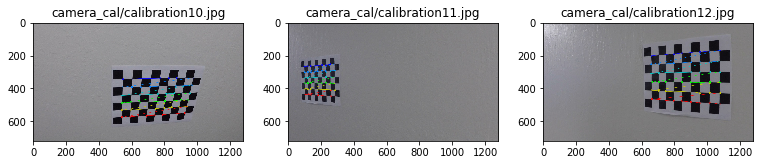

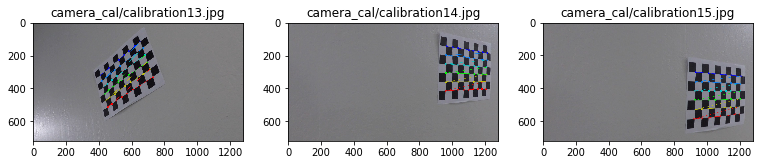

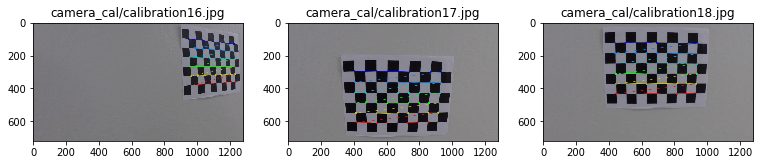

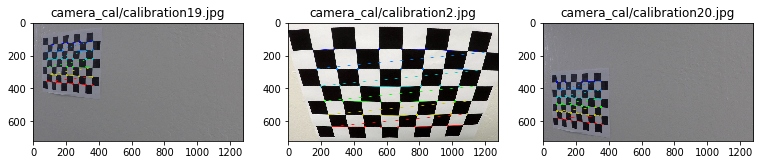

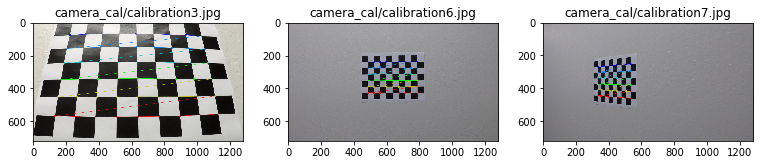

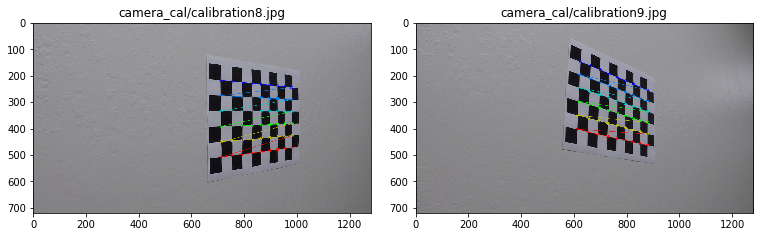

Failed on finding corners for the following images:
image #0, path: camera_cal/calibration1.jpg
image #14, path: camera_cal/calibration4.jpg
image #15, path: camera_cal/calibration5.jpg


In [4]:
print('Detected corners:')

for i in range(0,len(success_corners),3):
    display_images=[]
    im1= success_corners[i][0]
    display_images.append([im1,"{}".format(success_corners[i][1])])
    if (i+1) < len(success_corners):
        im2= success_corners[i+1][0]
        display_images.append([im2,"{}".format(success_corners[i+1][1])])
        if (i+2) < len(success_corners):
            im3= success_corners[i+2][0]
            display_images.append([im3,"{}".format(success_corners[i+2][1])])
    side2side_plotter(display_images)
    
print('Failed on finding corners for the following images:')
for i,im in failed_corners:
    print('image #{}, path: {}'.format(i,im))

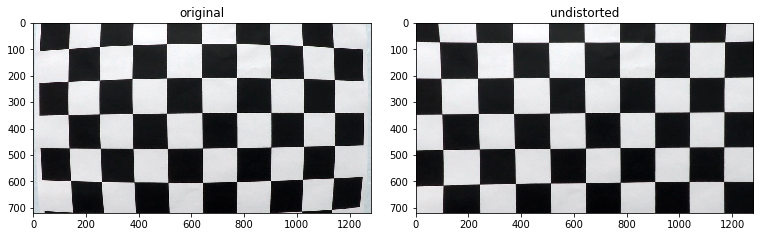

In [5]:
# step 2
def undistort(img):
    img_copy = np.copy(img)
    img_size=(img.shape[1],img_copy.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera( object_points, image_points, img_size,None,None)
    undistort_image = cv2.undistort(img_copy, mtx, dist, None, mtx)
    return undistort_image

# testing calibrate and undistort on an image that was not used in 
img = cv2.imread('camera_cal/calibration1.jpg')
undistort_image = undistort(img)
u_images = [[img,'original'], [undistort_image,'undistorted']]
side2side_plotter(u_images)

In [6]:
# Finding gradient binary
def gradient_binary(img, thresh=[90,200],orientation='x', ksize=3):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orientation=='y':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F,0,1, ksize=ksize)
    else:
        sobel = cv2.Sobel(gray_img, cv2.CV_64F,1,0, ksize=ksize)
    sobel_abs = np.absolute(sobel)
    sobel_scaled= np.uint8(255* sobel_abs/np.max(sobel_abs))
    sobel_binary = np.zeros_like(sobel_scaled)
    sobel_binary[(sobel_scaled>thresh[0])&(sobel_scaled<=thresh[1])]=1
    return sobel_binary

In [7]:
# converting image to HLS channel

def hls_binary(img, thresh=[90,200], channel='s'):
    hls_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS).astype(np.float)
    if channel =='h':
        hls_img = hls_img[:,:,0]
    elif channel == 'l':
        hls_img = hls_img[:,:,1]
    else:
        hls_img = hls_img[:,:,2]
    hls_binary= np.zeros_like(hls_img)
    hls_binary[(hls_img>thresh[0])&(hls_img<=thresh[1])]=1
    return hls_binary

In [8]:
def rgb_binary(img, thresh=[90,200], channel='r'):
    copy_img = np.copy(img)
    if channel =='r':
        copy_img = copy_img[:,:,0]
    elif channel == 'g':
        copy_img = copy_img[:,:,1]
    else:
        copy_img = copy_img[:,:,2]
    rgb_binary= np.zeros_like(copy_img)
    rgb_binary[(copy_img>thresh[0])&(copy_img<=thresh[1])]=1
    return rgb_binary

In [9]:
#step 3
def combine_binaries(binary_img1, binary_img2, return_color_combination=False):
    color_combination=[]
    if return_color_combination is True:
        color_combination = np.dstack((np.zeros_like(binary_img1), binary_img1, binary_img2))
    binary = np.zeros_like(binary_img1)
    binary[(binary_img1==1)|(binary_img2==1)]=1
    return binary, color_combination

In [10]:

# #testing sobel & hls
# test_img = mpimage.imread('test_images/test2.jpg')
# undistort_image = undistort(test_img)
# sobel_img = gradient_binary(undistort_image, thresh=[50,150])
# hls_img = hls_binary(undistort_image, thresh=[150,255])
# rgb_img = rgb_binary(undistort_image, thresh=[150,255])
# side2side_plotter([[test_img,'original'],[sobel_img,'sobel X'],[hls_img,'Channel S'],[rgb_img,'Channel R']])
# combined_binary, color_combination = combine_binaries(sobel_img, hls_img, True)
# combined_binary2, color_combination2 = combine_binaries(combined_binary, rgb_img, False)
# side2side_plotter([[color_combination,'Sobel X & Channel S'],[combined_binary,'HLS & Sobel Combined']])
# side2side_plotter([[combined_binary2,'HLS(S) & Sobel & RGB(R) Combined']])


In [11]:
#step 4
def get_perspective_transformation(img, src_vertices, dst_vertices):
    src =np.float32(src_vertices)
    dst=np.float32(dst_vertices)
    M = cv2.getPerspectiveTransform(src,dst)
    warped_image = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    return warped_image, M

In [12]:
# region of interest
def display_region(original_img , gray_img, src_vertices):
    img_copy = np.copy(original_img)
    pts = np.array(src_vertices, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img_copy,[pts],True,(255,0,0), thickness=3)
    return img_copy


In [13]:
# test region & warp
# test_img = mpimage.imread('test_images/test2.jpg')
# img_size = [combined_binary.shape[0],combined_binary.shape[1]]
# src_vertices =[[550,450],[700,450],[1200,700],[300,700]]
# offset = 200
# dst_vertices = [[offset,offset],[img_size[1]-1,offset],[img_size[1]-1,img_size[0]-1],[offset,img_size[0]-1]]
    
# img_region = display_region(test_img,combined_binary,src_vertices)
# warped_img, M = get_perspective_transformation(combined_binary,src_vertices,dst_vertices)
# side2side_plotter([[img_region,'Region of Interest'],[warped_img,'Warped Image']])


In [14]:
# step 5
# histogram | convolve

def reject_outliers(datax,datay, m=2):
    indicies= np.where(abs(datax - np.mean(datax)) < m * np.std(datax))[0]
    outputx= datax[indicies]
    outputy= datay[indicies]
    return outputx,outputy

def sliding_window_histogram(img, n_windows=9):
    try:
        good_left = []
        good_right = []
        img_output = np.dstack((img, img, img))*255
        histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)

        window_height = int(img.shape[0]/n_windows)
        #find halves
        midpoint= int(histogram.shape[0]/2)
        left_half = histogram[0:midpoint]
        right_half = histogram[midpoint:]

        #find nonzeros
        nonzero = img.nonzero()
        nonzero_x = np.array(nonzero[1])
        nonzero_y = np.array(nonzero[0])

        #get the base
        left_base = np.argmax(left_half, axis=0)
        right_base = np.argmax(right_half, axis=0)+midpoint

        left_current = left_base
        right_current = right_base

        max_pix = 100
        number_nonzeros = 500
        margin = 150
        left_margin  =150
        last_good_points_left = np.array([])
        last_good_points_right = np.array([])
        for i in range(n_windows):
            
            y_high = img.shape[0] - i*window_height
            y_low = img.shape[0] - (i+1)*window_height

            x_left_low = left_current-left_margin
            x_left_high = left_current+margin

            x_right_low = right_current-margin
            x_right_high = right_current+margin

            cv2.rectangle(img_output, (x_left_low, y_low) ,(x_left_high, y_high), (0,255,0),2)
            cv2.rectangle(img_output, (x_right_low, y_low) ,(x_right_high, y_high), (0,255,0),2)

            good_left_indexes = ((nonzero_x>x_left_low)&(nonzero_x<x_left_high)&(nonzero_y>y_low)&(nonzero_y<y_high)).nonzero()[0]
            good_right_indexes = ((nonzero_x>x_right_low)&(nonzero_x<x_right_high)&(nonzero_y>y_low)&(nonzero_y<y_high)).nonzero()[0]

            good_left.append(good_left_indexes)
            good_right.append(good_right_indexes)
            if len(good_left_indexes)>= max_pix :
                left_current= np.int(np.mean(nonzero_x[good_left_indexes]))
            if len(good_right_indexes)>= max_pix:
                right_current= np.int(np.mean(nonzero_x[good_right_indexes]))


        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(good_left)
        right_lane_inds = np.concatenate(good_right)

        # Extract left and right line pixel positions
        leftx = nonzero_x[left_lane_inds]
        lefty = nonzero_y[left_lane_inds] 
        rightx = nonzero_x[right_lane_inds]
        righty = nonzero_y[right_lane_inds] 
       
        # Fit a second order polynomial to each

        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        try:
            leftx, lefty= reject_outliers(leftx,lefty)
            left_fit = np.polyfit(lefty, leftx, 2)
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        except Exception as err:
            left_fitx=None
            left_fit=None

        try:
            rightx, righty= reject_outliers(rightx,righty)
            right_fit = np.polyfit(righty, rightx, 2)
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except Exception as err:
            right_fitx = None
            right_fit = None


        if right_fit is None or len(rightx) < number_nonzeros:
            if len(leftx)>number_nonzeros:
                right_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] + 2*int(img.shape[1]/3)-50
                right_fit = np.array([left_fit[0], left_fit[1], left_fit[2] + 2*int(img.shape[1]/3)-50])
                rightx = rightx + 2*int(img.shape[1]/3)
                righty = righty


        if left_fit is None or len(leftx) < number_nonzeros:
            if len(rightx)>number_nonzeros:
                left_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] - 2*int(img.shape[1]/3)+50
                left_fit = np.array([right_fit[0], right_fit[1], right_fit[2] - 2*int(img.shape[1]/3)+50])
                leftx = rightx -2*int(img.shape[1]/3)
                lefty = righty

        img_output[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
        img_output[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

        left_line = {'x':leftx, 'y':lefty, 'fitx':left_fitx, 'coefficient':left_fit, 'slope':0}
        right_line = {'x':rightx, 'y':righty, 'fitx':right_fitx, 'coefficient':right_fit, 'slope':0}
        print(left_fit)
        print(right_fit)
    except Exception as err:
        print(err)
    return img_output, left_line, right_line, ploty


In [15]:
# output_img, left_line, right_line, ploty = sliding_window_histogram(warped_img)
# plt.imshow(output_img)
# if left_line['fitx'] is not None:
#     plt.plot(left_line['fitx'], ploty, color='yellow')
# if right_line['fitx'] is not None:
#     plt.plot(right_line['fitx'], ploty, color='yellow')
# plt.xlim(0, warped_img.shape[1])
# plt.ylim(warped_img.shape[0], 0)
# plt.show()

In [16]:
def calculate_curve_slope_distance(warped_img, lines, ploty):
    curve = 500
    car_position = (warped_img.shape[1]/2)
    ym_per_pix = 30/warped_img.shape[0]# meters per pixel in y dimension
    xm_per_pix = 3.7/warped_img.shape[1]/2 # meters per pixel in x dimension
    meter_per_pixel={'x':xm_per_pix,'y':ym_per_pix}
    
    try:
        center_x_point= int(warped_img.shape[1]/2)
        y_eval = np.max(ploty)
        # Fit new polynomials to x,y in world space
        fit_cr_left = np.polyfit(lines['left']['y']*ym_per_pix, lines['left']['x']*xm_per_pix, 2)
        fit_cr_right = np.polyfit(lines['right']['y']*ym_per_pix, lines['right']['x']*xm_per_pix, 2)

        # Calculate the new radii of curvature
        curve_left = ((1 + (2*fit_cr_left[0]*y_eval*ym_per_pix + fit_cr_left[1])**2)**1.5) / np.absolute(2*fit_cr_left[0])
        curve_right = ((1 + (2*fit_cr_right[0]*y_eval*ym_per_pix + fit_cr_right[1])**2)**1.5) / np.absolute(2*fit_cr_right[0])
        lines['left']['curve']= curve_left
        lines['right']['curve']= curve_right
        center_of_image = int(warped_img.shape[1]/2)
        car_position = (((lines['right']['x'][0]+ lines['left']['x'][0])/2) -center_of_image) * xm_per_pix
    except Exception as err:
        print(err)
        pass
    finally:
        lines['distance'] = car_position
    return lines,meter_per_pixel 

In [17]:
# Create an image to draw the lines on
import math

flags = {'slope':False, 'distance':False, 'expected':False, 'curve':False}
def project_lines_to_road(img_resources, lines, meter_per_pixel, M):
    
    original_img = img_resources['original']
    warped_img = img_resources['warped']
    undistort_img = img_resources['undistorted']
    left_line = lines['left']
    right_line = lines['right']
    ploty = lines['ploty']
    curve= (lines['left']['curve'] + lines['right']['curve'])/2
    car_position = lines['distance']
    
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line['fitx'], ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line['fitx'], ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    cv2.putText(result,'curve_avg: {0:.2f}m'.format(curve),(850,50), font, 1,(255,255,255),2)
    
    cv2.putText(result,'distance_center: {0:.2f}m '.format(car_position),(850,100), font, 1,(255,255,255),2)
    cv2.putText(result,'slope : {}'.format(flags['slope']),(850,150), font, 1,(255,255,255),2)
    cv2.putText(result,'distance : {}'.format(flags['distance']),(850,200), font, 1,(255,255,255),2)
    cv2.putText(result,'expected : {}'.format(flags['expected']),(850,250), font, 1,(255,255,255),2)
    cv2.putText(result,'curve : {}'.format(flags['curve']),(850,300), font, 1,(255,255,255),2)

    return result


In [18]:
#test 
# image_res = {'original':test_img,'warped':warped_img,'undistorted':undistort_image}
# lines= {'left':left_line,'right':right_line, 'ploty':ploty}
# lines,meter_per_pixel = calculate_curve_slope_distance(warped_img, lines, ploty)
# output_img = project_lines_to_road(image_res, lines, meter_per_pixel,M)
# image_display(output_img)

In [19]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #avg distance
        self.avg_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.coefficients = None
        self.line =None
        
        
    

  
    
    def get_avg_coefficients(self,all_instances):
        count =1
        coefficients = all_instances[-1].coefficients
        if len(all_instances) >1:
            coefficients += all_instances[-2].coefficients
            count+=1
            if len(all_instances) >2:
                coefficients += all_instances[-3].coefficients
                count+=1
        avg_coefficients = (coefficients+self.coefficients)/(count+1)
        return avg_coefficients
    
    
    def populate(self,new_line,all_instances,meter_per_pixel):
        try:
            if new_line['fitx'] is not None and new_line['coefficient'] is not None:
                self.detected = True 
    #             self.current_fit = new_line['coefficient']
                self.current_fit = new_line['coefficient']
                self.radius_of_curvature = new_line['curve']
                self.line_base_pos = new_line['x'][0]*meter_per_pixel['x']
                self.allx = new_line['x']
                self.ally = new_line['y']

                if len(all_instances) > 0:
                    self.diffs = all_instances[-1].current_fit - self.current_fit
                    self.recent_xfitted = all_instances[-1].allx
                    self.bestx = (new_line['fitx']+all_instances[-1].bestx*len(all_instances))/(len(all_instances)+1)
                    self.best_fit = self.current_fit
                else:
                    self.recent_xfitted = new_line['fitx']
                    self.bestx =  new_line['fitx']
                    self.best_fit = new_line['coefficient']
                    self.diffs = None
                    self.current_fit = new_line['coefficient']
        except Exception as err:
            print(err)
        

In [20]:
def find_slope(coefficients, height):
    y_top = 0
    y_bottom = height
    x_top = coefficients[0]*y_top**2 + coefficients[1]*y_top +  coefficients[2]
    x_bottom = coefficients[0]*y_bottom**2 + coefficients[1]*y_bottom +  coefficients[2]
    m = (y_bottom - y_top)/(x_bottom-x_top)
    return m


def get_avg_coefficients(all_instances):
        count =1
        coefficients = all_instances[-1].current_fit
        if len(all_instances) >1:
            coefficients += all_instances[-2].current_fit
            count+=1
            if len(all_instances) >2:
                coefficients += all_instances[-3].current_fit
                count+=1
        avg_coefficients = coefficients/count
        return avg_coefficients
    
def get_avg_slope(all_instances,height):
    count = 1
    slope = find_slope(all_instances[-1].current_fit, height)
    if len(all_instances) >1:
        slope += find_slope(all_instances[-2].current_fit, height)
        count+=1
        if len(all_instances) >2:
            slope += find_slope(all_instances[-3].current_fit, height)
            count+=1
    avg_slope = slope/count
    return avg_slope
    
def evaluate(warped_img,new_lines, new_instances,all_instances , distance_offset_meter = 0.5, slope_offset=1, curve_offset =1000):
    flags = {'slope':False, 'distance':False, 'expected':False, 'curve':False}

    try:
        good_match = False
        good_left = True
        good_right = True
        
        y_mid = int(warped_img.shape[0]/2)

        #check distance, slope and curve
        if len(all_instances['left']) >0 and len(all_instances['right'])>0 :
            
            if new_instances['left'].detected is True and new_instances['right'].detected is True:
                good_match = True
                print('detected')
                
            if new_lines['distance']>distance_offset_meter:
                good_match = False
                flags['distance']= True
                print('distance')
                
            curve_avg = (new_instances['left'].radius_of_curvature + new_instances['right'].radius_of_curvature)/2
            
            if curve_avg > 1200 or curve_avg<250:
                good_match = False
                flags['curve']=True
                print('curve')
                
            
            #check for expected value
            expected_leftx = all_instances['left'][-1].current_fit[0]* new_lines['left']['y'][-1]**2 \
                            + all_instances['left'][-1].current_fit[1]*new_lines['left']['y'][-1] + all_instances['left'][-1].current_fit[2]
            expected_rightx = all_instances['right'][-1].current_fit[0]* new_lines['right']['y'][-1]**2 \
                            + all_instances['right'][-1].current_fit[1]*new_lines['right']['y'][-1] + all_instances['right'][-1].current_fit[2]
            
            if abs(expected_rightx - new_lines['right']['x'][-1])>50 or abs(expected_leftx - new_lines['left']['x'][-1])>50:
                good_match =False
                flags['expected']=True
                print('expected')
                    
            
            slope_left = find_slope(new_instances['left'].current_fit, warped_img.shape[0])
            avg_slope_left= get_avg_slope(all_instances['left'],warped_img.shape[0])
            
            slope_right = find_slope(new_instances['right'].current_fit, warped_img.shape[0])
            avg_slope_right= get_avg_slope(all_instances['right'],warped_img.shape[0])
            
            print(slope_right, slope_left)
            if abs(slope_right-avg_slope_right)>2 or abs(slope_left-avg_slope_left)>2:
                good_match=False
                flags['slope']=True
                print('slope')
            
                
        #first entry
        else:
            if new_instances['left'].detected is True and new_instances['right'].detected is True:
                good_match = True
                
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
        #append to list of lines
#         if len(all_instances['left']) >0 and len(all_instances['right']) >0:
#             #if current line is not good line, fill its parameter
#             print(flags, good_match)
#             if good_match is False:
#                 #copy both of the previous lines
#                 new_instances['left']= all_instances['left'][-1]
#                 new_instances['right']= all_instances['right'][-1]
#                 # Fit a second order polynomial to each
                
                
#                 #avg_coefficients_left = get_avg_coefficients(all_instances['left'])
#                 new_lines['left']['fitx'] = all_instances['left'][-1].current_fit[0]*ploty**2 + all_instances['left'][-1].current_fit[1]*ploty + all_instances['left'][-1].current_fit[2]
#                 new_lines['left']['x'] = all_instances['left'][-1].allx
#                 new_lines['left']['y'] = all_instances['left'][-1].ally
#                 new_lines['left']['coefficients'] =  all_instances['right'][-1].current_fit
                
#                 #avg_coefficients_right = get_avg_coefficients(all_instances['right'])
#                 new_lines['right']['fitx'] = all_instances['right'][-1].current_fit[0]*ploty**2 + all_instances['right'][-1].current_fit[1]*ploty + all_instances['right'][-1].current_fit[2]
#                 new_lines['right']['x'] = all_instances['right'][-1].allx
#                 new_lines['right']['y'] = all_instances['right'][-1].ally
#                 new_lines['right']['coefficients'] =  all_instances['right'][-1].current_fit
                
#                 #recalculate curve, slope and distaces
#                 new_lines, _ = calculate_curve_slope_distance(warped_img, new_lines, ploty)
#                 good_match= True
#             else:
#                 #using previous coefficients and take avg coefficient with the previous line
# #                 new_lines['left']['fitx'] = all_instances['left'][-1].current_fit[0]*ploty**2 + all_instances['left'][-1].current_fit[1]*ploty + all_instances['left'][-1].current_fit[2]
# #                 new_lines['left']['coefficient']  = (all_instances['left'][-1].current_fit+new_lines['left']['coefficient'])/2
#                 new_instances['left'].current_fit = new_lines['left']['coefficient'] 

# #                 new_lines['right']['fitx'] = all_instances['right'][-1].current_fit[0]*ploty**2 + all_instances['right'][-1].current_fit[1]*ploty + all_instances['right'][-1].current_fit[2]
# #                 new_lines['right']['coefficient']  = (all_instances['right'][-1].current_fit + new_lines['right']['coefficient'])/2
#                 new_instances['right'].current_fit = new_lines['right']['coefficient']

        all_instances['left'].append(new_instances['left'])
        all_instances['right'].append(new_instances['right'])
    except Exception as err:
        print('***')
        print(err)
        pass
    return all_instances, new_lines

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



def process_image(image):
    global all_instances
    output_image= np.copy(image)
    undistort_img = undistort(image)
    sobel_img = gradient_binary(undistort_image, thresh=[50,150])
    hls_img = hls_binary(undistort_image, thresh=[100,255])
#     rgb_img = rgb_binary(undistort_image, thresh=[150,255])

    combined_binary, color_combination = combine_binaries(sobel_img, hls_img, True)
#     combined_binary, _ = combine_binaries(combined_binary1, rgb_img, False)
    img_size = [combined_binary.shape[0],combined_binary.shape[1]]       
    
    dst_vertices = [[offset,offset],[img_size[1]-offset,offset],[img_size[1]-offset,img_size[0]-offset],[offset,img_size[0]-offset]]
    img_region = display_region(image,combined_binary,src_vertices)

    warped_img, M = get_perspective_transformation(combined_binary,src_vertices,dst_vertices)

    output_img, left_line, right_line, ploty = sliding_window_histogram(warped_img)
    new_lines = {'left':left_line, 'right':right_line, 'ploty':ploty}
    
    plt.imshow(output_img)
    if left_line['fitx'] is not None:
        plt.plot(left_line['fitx'], ploty, color='yellow')
    if right_line['fitx'] is not None:
        plt.plot(right_line['fitx'], ploty, color='yellow')
    plt.xlim(0, warped_img.shape[1])
    plt.ylim(warped_img.shape[0], 0)
    plt.show()
    
    new_lines, meter_per_pixel = calculate_curve_slope_distance(warped_img, new_lines, ploty)
    image_resources = {'original':image, 'warped':warped_img, 'undistorted':undistort_img}
#     left_instance = Line()
#     left_instance.populate(new_lines['left'],all_instances['left'], meter_per_pixel) 
#     right_instance = Line()
#     right_instance.populate(new_lines['right'],all_instances['right'], meter_per_pixel) 
#     new_instances = {'left': left_instance, 'right':right_instance}
    
#     all_instances,new_lines= evaluate(warped_img, new_lines, new_instances, all_instances)

    output_image = project_lines_to_road(image_resources,new_lines , meter_per_pixel,M)
    image_display(output_image)
    return output_image

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


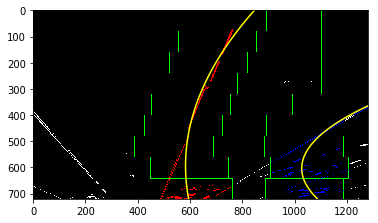

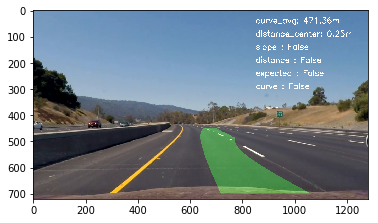

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4







  0%|          | 0/376 [00:00<?, ?it/s]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


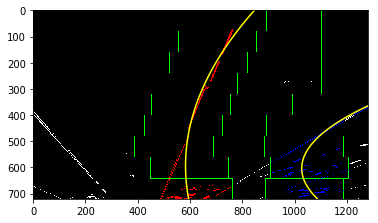

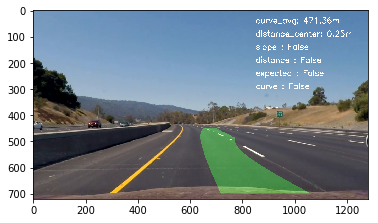






  0%|          | 1/376 [00:01<08:23,  1.34s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


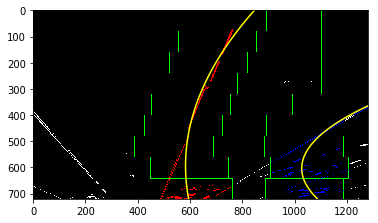

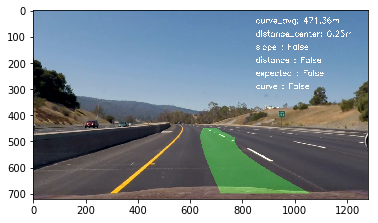






  1%|          | 2/376 [00:02<08:15,  1.32s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


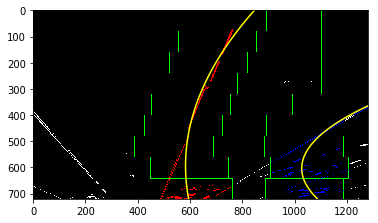

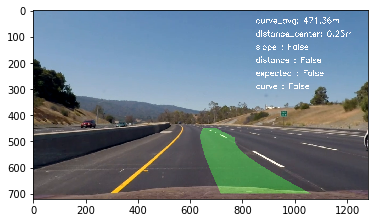






  1%|          | 3/376 [00:03<08:08,  1.31s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


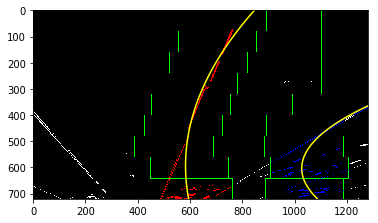

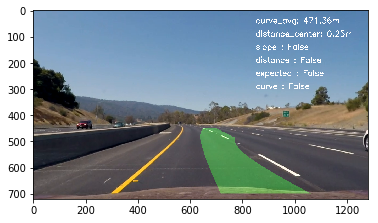






  1%|          | 4/376 [00:05<08:16,  1.33s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


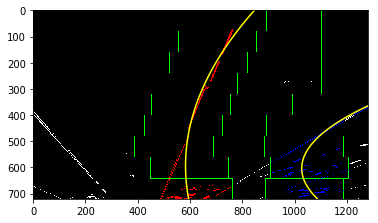

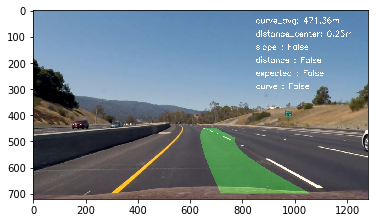






  1%|▏         | 5/376 [00:06<08:16,  1.34s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


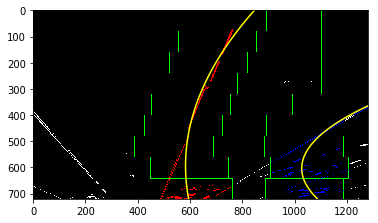

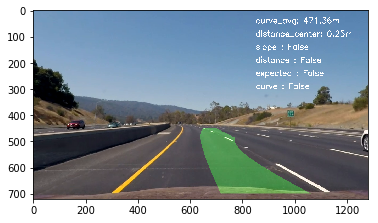






  2%|▏         | 6/376 [00:07<08:07,  1.32s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


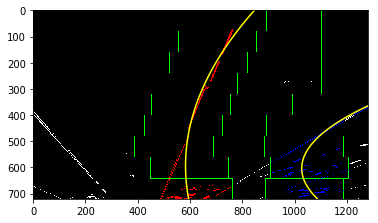

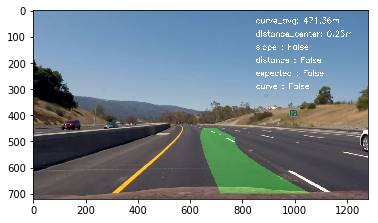






  2%|▏         | 7/376 [00:09<08:14,  1.34s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


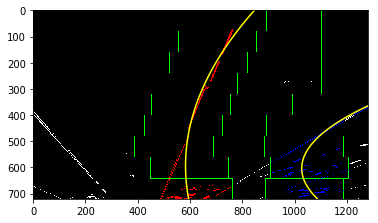

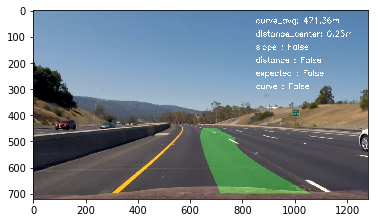






  2%|▏         | 8/376 [00:10<08:21,  1.36s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


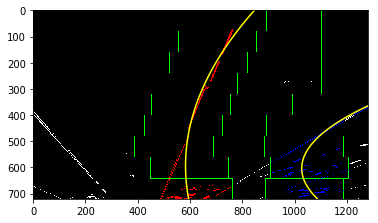

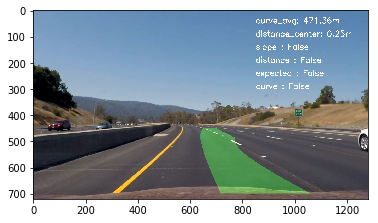






  2%|▏         | 9/376 [00:12<08:30,  1.39s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


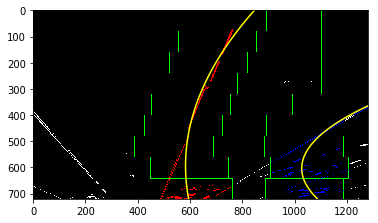

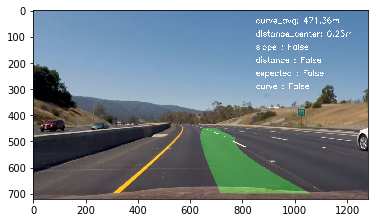






  3%|▎         | 10/376 [00:13<08:26,  1.39s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


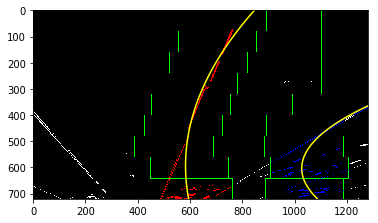

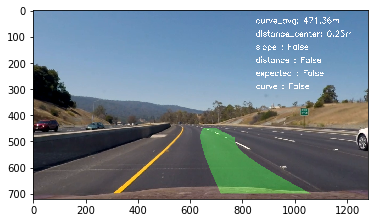






  3%|▎         | 11/376 [00:14<08:12,  1.35s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


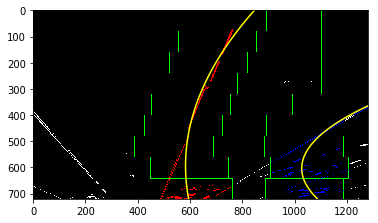

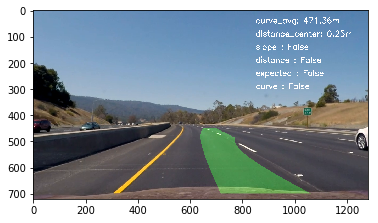






  3%|▎         | 12/376 [00:16<08:03,  1.33s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


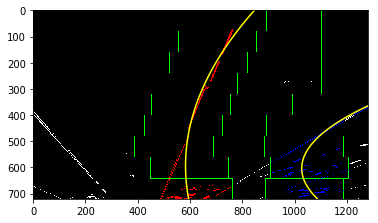

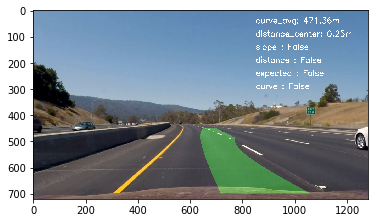






  3%|▎         | 13/376 [00:17<08:05,  1.34s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


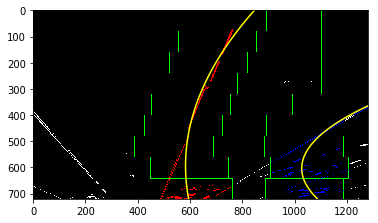

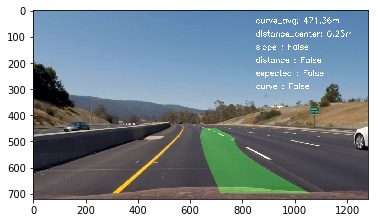






  4%|▎         | 14/376 [00:18<07:55,  1.31s/it]

[  7.44307239e-04  -8.84451626e-01   8.45566858e+02]
[  4.43284083e-03  -5.35175922e+00   2.64231506e+03]


KeyboardInterrupt: 

In [33]:
all_instances = {'left':[],'right':[]}

src_vertices =[[550,450],[700,450],[1200,700],[300,700]]
offset = 0 
video_output = 'project_output.mp4'
clip = VideoFileClip('project_video.mp4')
sub_clip = clip.subclip('00:00:05','00:00:20')
project_clip = sub_clip.fl_image(process_image)
%time project_clip.write_videofile(video_output, audio=False)

In [ ]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [ ]:
all_instances = {'left':[],'right':[]}
old_lines={}
consecutive_bad_matches=0
src_vertices =[[550,450],[700,450],[1200,700],[300,700]]
offset = 100
challenge_output = 'challenge_output.mp4'
clip = VideoFileClip('challenge_video.mp4')
challenge_clip = clip.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">S
</video>
""".format(challenge_output))

In [ ]:
both_lines = {'left':[],'right':[]}
src_vertices =[[400,600],[950,600],[1000,700],[200,700]]
offset = 100 
harder_challenge_output = 'harder_challenge_output.mp4'
clip = VideoFileClip('harder_challenge_video.mp4')
harder_challenge_clip = clip.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))